In [539]:
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Machine Learning Workshop
by Ethan Orlowsky and Geoff Brann

The Houston Astros defeated the Los Angeles Dodgers 4-3 in the 2019 World Series, a championship since tarnished by revelations of cheating. The Astros used an electronic system to collect and decipher opponent signs, and then relayed this information to their hitters, granting them an unfair advantage. An investigation performed by the MLB’s Department of Investigation resulted in a series of sanctions, including lost draft picks, a $5 million fine, and other punishments to members of the Astros’ front office. MLB’s disciplinary action did not extend to the players who themselves cheated, however, leading to mixed reactions from fans. This lack of closure, along with the novelty and egregiousness of the act, has inspired members of the baseball community to themselves take action, through research or conversation, to learn more about the method and extent of the Astros’ misconduct.

One of those impassioned fans is Tony Adams, a supporter of the Astros who was “horrified”, and was inspired to log each and every at bat by the Astros in that 2017 season, and from game audio was able to determine if and when a batter was notified that a certain pitch was about to be thrown. Adams’ work has opened an avenue for further research, including what we will attempt to do in this project. Adams determined when during the regular season Astros hitters were notified of incoming pitches, but was unable to do the same for the Postseason due to significant changes in stadium audio. The Commissioner’s report confirmed that cheating continued during the Postseason, but it is yet unknown when such cheating occurred. We hope to determine on which pitches cheating occurred in the 2017 Postseason, or if this can even be determined with certainty.


## TLDR
When did the Astros cheat in the playoffs, and how much did it help?

In [507]:
reg_df = pd.read_csv('reg_season_statcast_bangs.csv')
reg_df['bangs'] = reg_df['bangs'].fillna(0)
reg_df.loc[reg_df['bangs'] != 0, 'bangs'] = 1

playoff_df = pd.read_csv('post_season_statcast.csv')
playoff_df['bangs'] = 2

df = pd.concat([reg_df, playoff_df]).reset_index(drop=True)

df.loc[:,'score_diff'] = df.home_score - df.away_score
df.drop(['home_score', 'away_score'], axis=1, inplace=True)

## Feature Selection

We want to narrow down our dataset by selecting only the columns that matter. You should get rid of a feature if:
<ul>
    <li> it has a lot of null values
    <li> it doesn't have a lot of variance
    <li> it couldn't possibly have been available at the time of the decision
    <li> it has no predictive power
    <li> it contains the same information as other columns
</ul>

In [508]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

### Finding the amount of null values in each column

In [509]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9567 entries, 0 to 9566
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       9531 non-null   object 
 1   game_date                        9567 non-null   object 
 2   release_speed                    9531 non-null   float64
 3   release_pos_x                    9531 non-null   float64
 4   release_pos_z                    9531 non-null   float64
 5   player_name                      9567 non-null   object 
 6   batter                           9567 non-null   int64  
 7   pitcher                          9567 non-null   int64  
 8   events                           2475 non-null   object 
 9   description                      9567 non-null   object 
 10  spin_dir                         0 non-null      float64
 11  spin_rate_deprecated             0 non-null      float64
 12  break_angle_deprecat

In [510]:
num_cols_before = len(df.columns)

df = df.loc[:, df.isna().sum(axis=0) < 200]

num_cols_after = len(df.columns)

print(f"We reduced the number of columns from {num_cols_before} to {num_cols_after}")

We reduced the number of columns from 92 to 66


### Finding the columns with not a lot of variance

In [511]:
df.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,score_diff
count,9531.000000,9531.000000,9531.000000,9567.000000,9567.000000,9531.000000,9567.000000,9567.000000,9567.0,9531.000000,9531.000000,9531.000000,9531.000000,9567.000000,9567.000000,9567.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9433.000000,9380.000000,9531.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9531.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9531.000000,9567.000000,9566.000000,9567.000000
mean,88.286098,-0.908558,5.882572,504547.195464,530874.841957,9.633512,0.923592,0.861294,2017.0,-0.306336,0.546814,0.075344,2.077876,0.972405,4.788335,515917.420194,3.041137,-128.132200,-4.286186,-4.375009,25.966785,-24.618689,3.440473,1.579966,87.732058,2251.172814,6.068230,495973.068360,530874.841957,515917.420194,516659.361242,506653.837880,525564.635832,563931.914393,521714.489600,556242.181144,551382.171423,54.443608,38.970419,2.924741,2.465454,2.105362,2.105362,2.499321,2.499321,2.105362,182.862239,0.000411,0.002536,0.360092
std,5.969068,1.856905,0.478025,121850.111754,80896.942715,4.094898,0.978931,0.818645,0.0,0.865768,0.806246,0.863224,0.962689,0.827016,2.562176,60393.346715,5.651410,8.629595,3.113213,10.244764,3.568912,9.239232,0.285351,0.190918,7.249770,319.022858,0.514234,12086.577168,80896.942715,60393.346715,65906.952690,70569.636026,92923.326247,52636.831878,64437.788982,57525.512631,70336.441205,0.514832,22.167474,1.775852,2.848762,2.353413,2.353413,2.862698,2.862698,2.353413,81.441294,0.031576,0.249637,2.675660
min,64.800000,-4.990000,3.740000,136860.000000,112526.000000,1.000000,0.000000,0.000000,2017.0,-2.070000,-2.250000,-3.390000,-1.790000,0.000000,1.000000,425772.000000,-17.389574,-148.421756,-17.577541,-27.966240,14.741083,-53.279976,2.660000,1.060000,0.000000,761.000000,4.000000,490111.000000,112526.000000,425772.000000,408045.000000,400284.000000,134181.000000,444876.000000,434658.000000,434658.000000,425783.000000,52.690000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.391000,-1.091000,-9.000000
25%,84.200000,-2.120000,5.600000,493329.000000,477132.000000,6.000000,0.000000,0.000000,2017.0,-1.060000,0.040000,-0.520000,1.460000,0.000000,3.000000,455117.000000,-0.202453,-134.679576,-6.490033,-13.230095,23.294695,-31.362385,3.260000,1.460000,83.700000,2118.000000,5.700000,490598.000000,477132.000000,455117.000000,474892.000000,446381.000000,472528.000000,516416.000000,458731.000000,534606.000000,466988.000000,54.090000,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.000000,0.000000,-0.068000,-1.000000
50%,89.500000,-1.470000,5.920000,514888.000000,533167.000000,11.000000,1.000000,1.000000,2017.0,-0.390000,0.710000,0.080000,2.070000,1.000000,5.000000,518960.000000,4.528298,-129.833420,-4.498803,-4.803649,26.065667,-23.475903,3.460000,1.590000,89.100000,2291.000000,6.100000,491440.000000,533167.000000,518960.000000,502143.000000,502517.000000,543685.000000,588751.000000,502481.000000,547982.000000,592325.000000,54.400000,38.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,204.000000,0.000000,0.000000,0.000000
75%,92.800000,-0.245000,6.220000,594828.000000,596057.000000,13.000000,2.000000,2.000000,2017.0,0.400000,1.190000,0.670000,2.700000,2.000000,7.000000,572287.000000,6.995406,-122.170392,-2.132162,3.736119,28.607121,-17.012876,3.

The 'game_year' column has no variance, because all entries are 2017, so we can remove it

In [512]:
df.drop(['game_year'], axis=1, inplace=True)

### Determining which columns couldn't have been known at the time

We are interested in predicting whether the Astros dugout banged the trash can on each pitch in the playoffs. When deciding whether to bang, the Astros knew the game situation (i.e. inning, outs, score, etc.), but they did not know what the spin rate of the pitch was going to be

In [513]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'description',
       'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team',
       'away_team', 'type', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'outs_when_up', 'inning', 'inning_topbot', 'fielder_2',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'at_bat_number', 'pitch_number', 'pitch_name', 'bat_score', 'fld_score',
       'post_away_score', 'post_home_score', 'post_bat_score',
       'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
       'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'bangs',
       'score_diff'],
      dtype='object')

In [514]:
keep_cols = ['pitch_type', 'game_date', 'player_name', 'batter', 'pitcher', 'game_type', 
       'stand', 'p_throws', 'home_team', 'away_team', 'balls', 'strikes', 'outs_when_up', 
       'inning', 'inning_topbot', 'fielder_2', 'game_pk', 'pitcher.1', 'fielder_2.1', 
       'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
       'fielder_9', 'at_bat_number', 'pitch_number', 'pitch_name', 'bat_score', 'fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp', 
       'score_diff', 'bangs']

In [515]:
num_cols_before = len(df.columns)

df = df.loc[:,keep_cols]

num_cols_after = len(df.columns)

print(f"We reduced the number of columns from {num_cols_before} to {num_cols_after}")

We reduced the number of columns from 65 to 37


### Determing which columns have no predictive power

Some columns have information that is not helpful for predicting whether the Astros banged on a given pitch. It could be irrelevant, or have so much variance that it would be impossible for the model to generalize on.

For example, the person in right field should have little to no impact on the Astros decision to bang.

Additionally, there are so many different possible pitchers the Astros could face, that it is very likely they come across a pitcher that they haven't seen before, or haven't faced for that many at bats. We don't want to mislead our model by saying that there is a low chance of banging against a specific pitcher just because they haven't faced the Astros many times.

In [516]:
df.columns

Index(['pitch_type', 'game_date', 'player_name', 'batter', 'pitcher',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'balls',
       'strikes', 'outs_when_up', 'inning', 'inning_topbot', 'fielder_2',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'at_bat_number', 'pitch_number', 'pitch_name', 'bat_score', 'fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp',
       'delta_run_exp', 'score_diff', 'bangs'],
      dtype='object')

In [517]:
keep_cols = ['pitch_type', 'player_name', 'batter', 'stand', 'p_throws', 'balls',
       'strikes', 'outs_when_up', 'inning', 'pitch_number', 'pitch_name', 'bat_score', 
       'fld_score', 'delta_home_win_exp', 'delta_run_exp', 'score_diff', 'bangs']

In [518]:
num_cols_before = len(df.columns)

df = df.loc[:,keep_cols]

num_cols_after = len(df.columns)

print(f"We reduced the number of columns from {num_cols_before} to {num_cols_after}")

We reduced the number of columns from 37 to 17


### Getting rid of duplicate columns

Some columns have the same information represented in different ways. For example, we have a 'pitch_type' and 'pitch_name' column. There is no need for both columns because they say the same things

In [519]:
df[['pitch_type', 'pitch_name']].head()

,pitch_type,pitch_name
0,SI,Sinker
1,SI,Sinker
2,SL,Slider
3,SI,Sinker
4,FF,4-Seam Fastball


In [520]:
keep_cols = ['pitch_type', 'batter', 'stand', 'p_throws', 'balls', 'strikes',
       'outs_when_up', 'inning', 'pitch_number', 'score_diff', 'delta_home_win_exp', 
       'delta_run_exp', 'bangs']
non_feature_cols = ['delta_home_win_exp', 'delta_run_exp', 'bangs']

In [521]:
num_cols_before = len(df.columns)

df = df.loc[:, keep_cols]

num_cols_after = len(df.columns)

print(f"We reduced the number of columns from {num_cols_before} to {num_cols_after}")


We reduced the number of columns from 17 to 13


### Getting rid of all rows with nulls

Before we got rid of all the columns with more than 200 null values. However, there could still be some columns with nulls still left in our dataset. Instead of getting rid of these columns, we can get rid of the few rows with nulls

In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9567 entries, 0 to 9566
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pitch_type          9531 non-null   object 
 1   batter              9567 non-null   int64  
 2   stand               9567 non-null   object 
 3   p_throws            9567 non-null   object 
 4   balls               9567 non-null   int64  
 5   strikes             9567 non-null   int64  
 6   outs_when_up        9567 non-null   int64  
 7   inning              9567 non-null   int64  
 8   pitch_number        9567 non-null   int64  
 9   score_diff          9567 non-null   int64  
 10  delta_home_win_exp  9567 non-null   float64
 11  delta_run_exp       9566 non-null   float64
 12  bangs               9567 non-null   object 
dtypes: float64(2), int64(7), object(4)
memory usage: 971.8+ KB


In [523]:
df = df[df.isna().sum(axis=1) == 0].reset_index(drop=True)

In [524]:
df.head()

,pitch_type,batter,stand,p_throws,balls,strikes,outs_when_up,inning,pitch_number,score_diff,delta_home_win_exp,delta_run_exp,bangs
0,SI,543807,R,R,0,0,0,1,1,0,0.000,0.036,0
1,SI,543807,R,R,1,0,0,1,2,0,0.000,-0.046,0
2,SL,543807,R,R,1,1,0,1,3,0,0.000,0.050,0
3,SI,543807,R,R,2,1,0,1,4,0,0.102,0.960,0
4,FF,608324,R,R,0,0,0,1,1,1,0.030,0.387,0


## Preprocessing

Machine Learning models need data that is in a numerical format. So, we must transform any text data we have into some sort of numerical encoding. For the algorithm I will be using later, I need all of my data to be categorical with categories labeled from 0 to n, where n is the number of categories for that feature.

In [525]:
cat_df = df.copy()
for col in cat_df.columns:
    if col not in non_feature_cols:
        cat_df[col] = cat_df[col].astype('category').cat.codes

In [526]:
cat_df.head()

,pitch_type,batter,stand,p_throws,balls,strikes,outs_when_up,inning,pitch_number,score_diff,delta_home_win_exp,delta_run_exp,bangs
0,7,9,1,1,0,0,0,0,0,8,0.000,0.036,0
1,7,9,1,1,1,0,0,0,1,8,0.000,-0.046,0
2,8,9,1,1,1,1,0,0,2,8,0.000,0.050,0
3,7,9,1,1,2,1,0,0,3,8,0.102,0.960,0
4,4,16,1,1,0,0,0,0,0,9,0.030,0.387,0


## Splitting our data into training and testing sets

In the very beginning, I labeled all the playoff data with a 2 in the bangs category as an indicator (and also since there was no bangs column, so I didn't overwrite any important information). I can now use this to split my data into train and test sets

In [527]:
train_mask = cat_df.bangs != 2

In [528]:
x_train = cat_df[train_mask].copy().drop(non_feature_cols, axis=1)
x_test = cat_df[~train_mask].copy().drop(non_feature_cols, axis=1)

y_train = cat_df.loc[train_mask, 'bangs']
y_train = y_train.astype('category').cat.codes

## Training our Model

Training a model is easy once you have your data cleaned exactly the way it needs to be. Actually training your model can be done in 1 line of code!

In [568]:
clf = CategoricalNB().fit(x_train, y_train)

## Evaluating the results

In [570]:
# predict the bang probability for each pitch in our test set (playoffs)
bang_probability = clf.predict_proba(x_test)
bang_probability = pd.Series(list(map(lambda x: x[1], bang_probability)), name='bang_probability')

In [564]:
test_deltas = df.loc[~train_mask, ['delta_home_win_exp', 'delta_run_exp']].reset_index(drop=True)

In [571]:
res = df.loc[~train_mask, ['delta_home_win_exp', 'delta_run_exp']].reset_index(drop=True)
res['bang_probability'] = bang_probability

# probability of a bang * gain from the pitch = expected gain from banging
res['exp_delta_win_exp'] = res['bang_probability'] * res['delta_home_win_exp']
res['exp_delta_runs'] = res['bang_probability'] * res['delta_run_exp']

In [572]:
runs_gained = res.exp_delta_runs.sum()
win_exp_gained = res.exp_delta_win_exp.sum()

print(f"The Astros gained approximately {runs_gained:.2f} runs in the playoffs")
print(f"The Astros gained approximately {win_exp_gained:.2f} of win expectancy in the playoffs")

The Astros gained approximately 1.75 runs in the playoffs
The Astros gained approximately 0.26 of win expectancy in the playoffs


[]

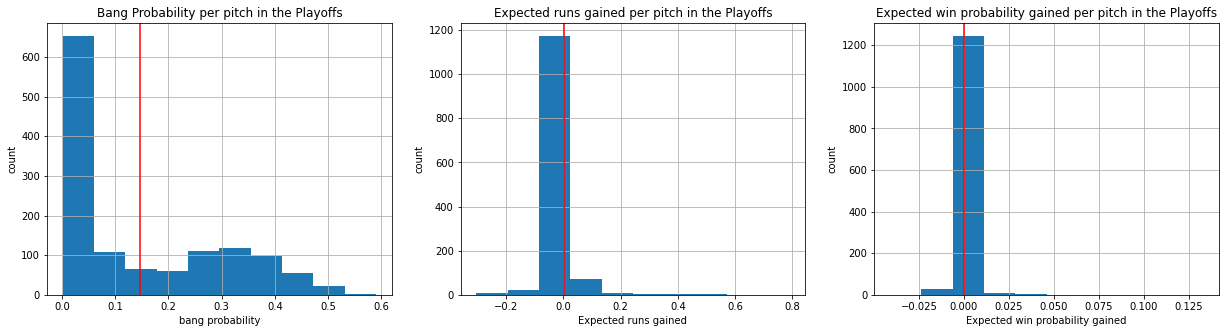

In [573]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))

res.bang_probability.hist(ax=ax[0])
res.exp_delta_runs.hist(ax=ax[1])
res.exp_delta_win_exp.hist(ax=ax[2])

ax[0].set_title('Bang Probability per pitch in the Playoffs')
ax[0].set_xlabel('bang probability')
ax[0].set_ylabel('count')
ax[0].axvline(res.bang_probability.mean(), color='red')

ax[1].set_title('Expected runs gained per pitch in the Playoffs')
ax[1].set_xlabel('Expected runs gained')
ax[1].set_ylabel('count')
ax[1].axvline(res.exp_delta_runs.mean(), color='red')

ax[2].set_title('Expected win probability gained per pitch in the Playoffs')
ax[2].set_xlabel('Expected win probability gained')
ax[2].set_ylabel('count')
ax[2].axvline(res.exp_delta_win_exp.mean(), color='red')

plt.plot()